In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
import os
from faces_clustering import get_files_folder, VideoClustering, is_image

Using TensorFlow backend.


In [2]:
video_path = "C:/Users/paulo/Documents/videos360/vlog_gelo.mp4"

In [3]:
dir_path = video_path.split('.')[0]
dir_path

'C:/Users/paulo/Documents/videos360/vlog_gelo'

## Extracting Frames

In [ ]:
cap=cv2.VideoCapture(video_path)
fps = int(round(cap.get(cv2.CAP_PROP_FPS)))

if os.path.isdir(dir_path):
    os.rmdir(dir_path)
os.mkdir(dir_path)

In [ ]:
i=1
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    if i%fps == 0:
        cv2.imwrite(f'{dir_path}/frame_{i}.jpg',frame)
    i+=1

## Extracting Viewports

In [4]:
from faces_clustering import Equirec2Perspec as E2P
from mtcnn import MTCNN

In [5]:
import cv2
import numpy as np
from shapely import geometry

In [6]:
def detect_faces(pixels_rgb):
    
    detector = MTCNN()
    results = detector.detect_faces(pixels_rgb)
    
    faces = []
    bounds = []
    confidences = []
    for result in results:
        if result['confidence'] >= 0.7:
            x1, y1, width, height = result['box']
            x2, y2 = x1 + width, y1 + height
            x1 = max(x1,0)
            y1 = max(y1,0)
            face = pixels_rgb[y1:y2, x1:x2]

            if face.shape[0] > 0 and face.shape[1] > 0:
                faces.append(face)
                bounds.append((x1,x2,y1,y2))
                confidences.append(result['confidence'])
                pixels_rgb = cv2.rectangle(pixels_rgb, (x1,y1), (x2,y2), (255,0,0), 5)
                
    return pixels_rgb, bounds, confidences

In [7]:
frames = get_files_folder(dir_path, is_image)
frames

['C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1008.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1032.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1056.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1080.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1104.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1128.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1152.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1176.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_120.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1200.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1224.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1248.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1272.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1296.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1320.jpg',
 'C:/Users/paulo/Documents

In [34]:
#equ = E2P.Equirectangular('C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1776.jpg')
equ = E2P.Equirectangular('C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_4272.jpg')
#equ = E2P.Equirectangular('C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_7464.jpg')
#equ = E2P.Equirectangular("C:/Users/paulo/Pictures/equ_earth.png")

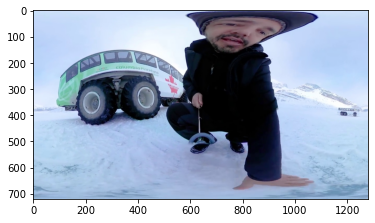

In [35]:
plt.imshow(equ._img[:,:,::-1])

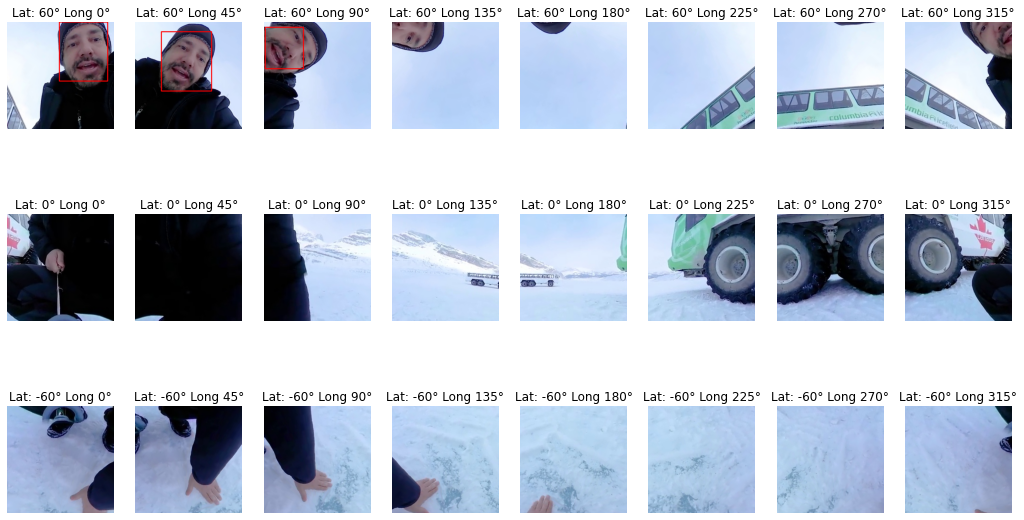

In [40]:
all_bounds = []
eq_bounds = []
all_confs = [] #all confidences from detected faces in all lat long coordinates

rows, cols = 3,8
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 10))
fovw = 60
fovh = 60
width = 720


for i in range(rows):
    for j in range(cols):
        lat = i*(-60)+60
        long = 45*j
        img, long_map, lat_map = equ.GetPerspective(fovw, fovh, long, lat, width)    
        img, bounds, confidences = detect_faces(np.uint16(img[:,:,::-1])) #x1,x2,y1,y2       
        
        for bound in bounds:
            x1, x2, y1, y2 = bound
            x1, x2 = min([x1,x2]),max([x1,x2])
            y1, y2 = min([y1,y2]),max([y1,y2])
            points = []
            
            for x in range(x1,x2+1):
                new_point = (int(long_map[y1, x]), int(lat_map[y1, x]))                
                if new_point not in points:
                    points = points+[new_point]
            for y in range(y1,y2+1):
                new_point = (int(long_map[y, x2]), int(lat_map[y, x2]))
                if new_point not in points:
                    points = points+[new_point]
            for x in range(x2,x1-1,-1):
                new_point = (int(long_map[y2, x]), int(lat_map[y2, x]))
                if new_point not in points:
                    points = points+[new_point]
            for y in range(y2,y1-1,-1):
                new_point = (int(long_map[y, x1]), int(lat_map[y, x1]))
                if new_point not in points:
                    points = points+[new_point]
                    
            eq_bounds = eq_bounds+[points]
            all_confs = all_confs+[confidences]
        all_bounds = all_bounds+bounds

        axes[i,j].set_title(f'Lat: {lat}° Long {long}°')
        axes[i,j].imshow(img)
        axes[i,j].axis('off')
plt.show()

In [41]:
def non_maximum_supression(B, S, nt):
    D = []
    B_back = B
    B = B.copy()
    while len(B) > 0:
        m = np.argmax(S)
        M = B[m]
        D.append(B_back.index(B[m]))
        B.pop(m)
        
        to_remove = []
        for i in range(len(B)):
            iou = M.intersection(B[i]).area/M.union(B[i]).area
            if iou >= nt:
                to_remove.append(i)
                
        for i in sorted(to_remove, reverse=True):
            B.pop(i)
            S.pop(i)
    return D
        

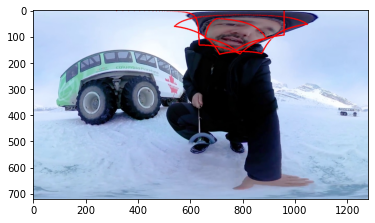

In [42]:
eq_img = np.uint16(equ._img[:,:,::-1])
eq_img.shape
polys = []

for eq_bound in eq_bounds:
    
    polys.append(geometry.Polygon(eq_bound))
    for point in eq_bound:
        cv2.circle(eq_img, point, 2, (255, 0, 0))
        
plt.imshow(eq_img)
plt.show()

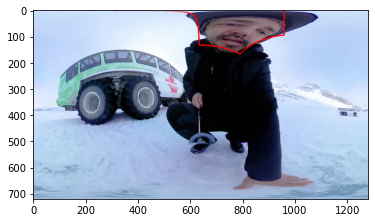

In [43]:
D = non_maximum_supression(polys, all_confs.copy(), 0.3)

eq_img = np.uint16(equ._img[:,:,::-1])
eq_img.shape
nms_bounds = [eq_bounds[d] for d in D]
for bound in nms_bounds:
    
    for point in bound:
        cv2.circle(eq_img, point, 2, (255, 0, 0))
        
plt.imshow(eq_img)
plt.show()